In [1]:
!pip install pandas
!pip install QuantLib

In [2]:
import pandas as pd
import QuantLib as ql

from app.service.YieldCurve.NoteBooks import NotebookHelper

%matplotlib inline

In [3]:
tenor_points = NotebookHelper.build_points(NotebookHelper.sofr_swaps)

{'benchmark_points': [{'tenor': '0 day', 'rate': 0.050694339}, {'tenor': '1 week', 'rate': 0.051482818}, {'tenor': '2 week', 'rate': 0.050516581}, {'tenor': '1 month', 'rate': 0.050693418}, {'tenor': '2 month', 'rate': 0.051183173}, {'tenor': '3 month', 'rate': 0.052179246}, {'tenor': '4 month', 'rate': 0.053034023}, {'tenor': '5 month', 'rate': 0.053390716}, {'tenor': '6 month', 'rate': 0.052693244}, {'tenor': '7 month', 'rate': 0.052695327}, {'tenor': '8 month', 'rate': 0.052394946}, {'tenor': '9 month', 'rate': 0.051137664}, {'tenor': '10 month', 'rate': 0.054207728}, {'tenor': '11 month', 'rate': 0.05471223}, {'tenor': '12 month', 'rate': 0.058945942}]}


In [4]:
settings = NotebookHelper.Settings()
ql.Settings.instance().evaluationDate = settings.today

settings.calendar = ql.UnitedStates(ql.UnitedStates.Settlement)
#settings.index = ql.Sofr()
#https://quant.stackexchange.com/questions/37532/set-up-overnightindex-quantlib
settings.index = ql.OvernightIndex("SOFR", settings.settlement_days, ql.USDCurrency(), settings.calendar, settings.day_counter)


settings.target_day = settings.today + 95

This section build the instruments using the tenor and yields from the Yield from Source

In [5]:
raw_index_tenor = []
raw_yield = []
helpers = ql.RateHelperVector()
count = 0
for point in tenor_points['benchmark_points']:
    rate = point['rate']
    tenor = NotebookHelper.get_tenor(point['tenor'])

    raw_yield.append(rate)
    raw_index_tenor.append(settings.today + tenor)

    if count == 0:
        count += 1
        helpers.append(ql.DepositRateHelper(rate,
                                               tenor,
                                               settings.fixing_days,
                                               settings.calendar,
                                               settings.convention,
                                               settings.end_of_month,
                                               settings.day_counter))
    else:
        '''
        helpers.append(ql.SwapRateHelper(
                        rate,#rate
                        tenor,#tenor
                        settings.calendar,#calendar
                        settings.fixed_frequency,#fixedFrequency
                        settings.convention,#fixedConvention
                        settings.day_counter,#fixedDayCount
                        settings.index))
        '''
        helpers.append(ql.OISRateHelper(2,
                       tenor,
                       ql.QuoteHandle(ql.SimpleQuote(rate)),
                       settings.index)
            )
        '''
        quote = ql.QuoteHandle(ql.SimpleQuote(rate))
        yts = ql.FlatForward(0, ql.TARGET(), quote, ql.Actual365Fixed() )
        ytsh = ql.YieldTermStructureHandle(yts)
        oishelper = ql.OISRateHelper(2, tenor, quote, ql.Sofr(ytsh), ytsh, True)
        helpers.append(oishelper)
        '''

df_raw_yields = pd.DataFrame(index=raw_index_tenor, columns=['Yield'], data=raw_yield)
display(df_raw_yields)


,Yield
"June 7th, 2023",0.050694
"June 14th, 2023",0.051483
"June 21st, 2023",0.050517
"July 7th, 2023",0.050693
"August 7th, 2023",0.051183
"September 7th, 2023",0.052179
"October 7th, 2023",0.053034
"November 7th, 2023",0.053391
"December 7th, 2023",0.052693
"January 7th, 2024",0.052695


<Axes: title={'center': 'Benchmark Rates'}, xlabel='Tenor', ylabel='Yield'>

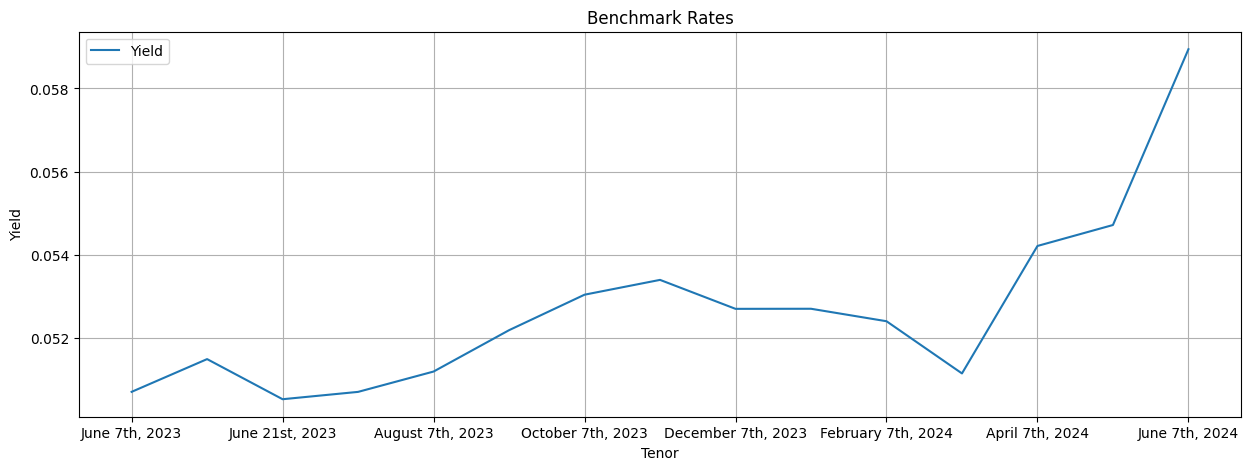

In [6]:
df_raw_yields.plot(figsize=(15,5), ylabel='Yield', xlabel='Tenor', grid=True, title='Benchmark Rates')

In [7]:
params = [0, settings.calendar, helpers, settings.day_counter]

methods_curves = {
    "PiecewiseFlatForward": ql.PiecewiseFlatForward(*params),
    #"LogLinearDiscount": ql.PiecewiseLogLinearDiscount(*params),
    "LogCubicDiscount": ql.PiecewiseLogCubicDiscount(*params),
    "LinearZero": ql.PiecewiseLinearZero(*params),
    #"CubicZero": ql.PiecewiseCubicZero(*params),
    #  "LinearForward": ql.PiecewiseLinearForward(*params),
    #SplineCubicDiscount": ql.PiecewiseSplineCubicDiscount(*params)
}

df_index_tenors = pd.DataFrame(index=[row[0] for row in list(methods_curves.values())[0].nodes()])
[methods_curves[curve].enableExtrapolation() for curve in methods_curves]
end_date = list(methods_curves.values())[0].maxDate()
reference_date = list(methods_curves.values())[0].referenceDate()
curve_dates = [ ql.Date(serial) for serial in range(reference_date.serialNumber(), end_date.serialNumber()+1) ]
index_curve_name = methods_curves.keys()

display(df_index_tenors)

""
"June 7th, 2023"
"June 16th, 2023"
"June 23rd, 2023"
"July 10th, 2023"
"August 9th, 2023"
"September 11th, 2023"
"October 10th, 2023"
"November 9th, 2023"
"December 11th, 2023"
"January 9th, 2024"


0 - June 7th, 2023: 0.050694339
1 - June 14th, 2023: 0.051482818
2 - June 21st, 2023: 0.050516581
3 - July 7th, 2023: 0.050693418
4 - August 7th, 2023: 0.051183173
5 - September 7th, 2023: 0.052179246
6 - October 7th, 2023: 0.053034023
7 - November 7th, 2023: 0.053390716
8 - December 7th, 2023: 0.052693244
9 - January 7th, 2024: 0.052695327
10 - February 7th, 2024: 0.052394946
11 - March 7th, 2024: 0.051137664
12 - April 7th, 2024: 0.054207728
13 - May 7th, 2024: 0.05471223
14 - June 7th, 2024: 0.058945942


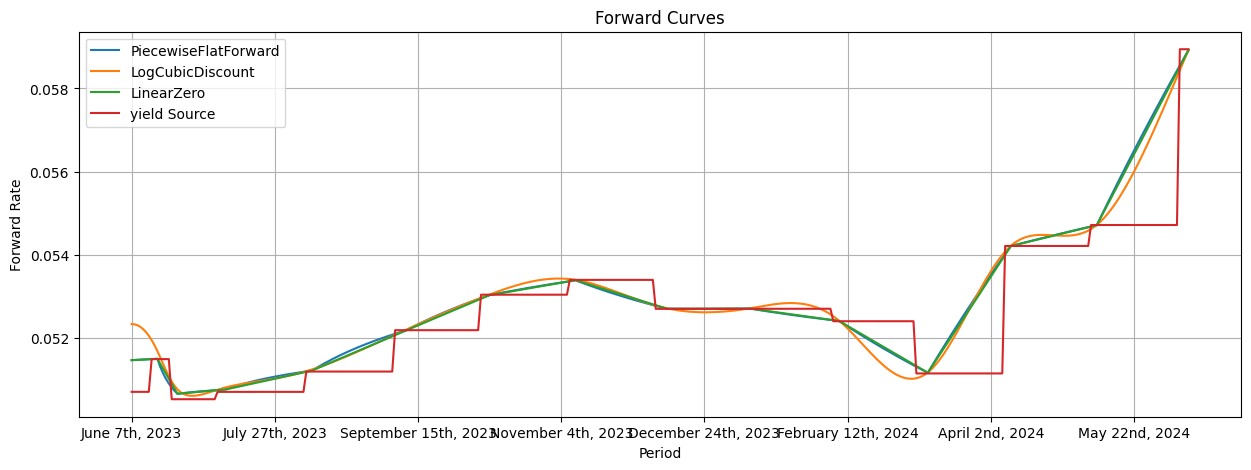

In [8]:
NotebookHelper.plot_forward_rates(curve_dates, methods_curves, settings, index_curve_name, df_raw_yields)

0 - June 7th, 2023: 0.050694339
1 - June 14th, 2023: 0.051482818
2 - June 21st, 2023: 0.050516581
3 - July 7th, 2023: 0.050693418
4 - August 7th, 2023: 0.051183173
5 - September 7th, 2023: 0.052179246
6 - October 7th, 2023: 0.053034023
7 - November 7th, 2023: 0.053390716
8 - December 7th, 2023: 0.052693244
9 - January 7th, 2024: 0.052695327
10 - February 7th, 2024: 0.052394946
11 - March 7th, 2024: 0.051137664
12 - April 7th, 2024: 0.054207728
13 - May 7th, 2024: 0.05471223
14 - June 7th, 2024: 0.058945942


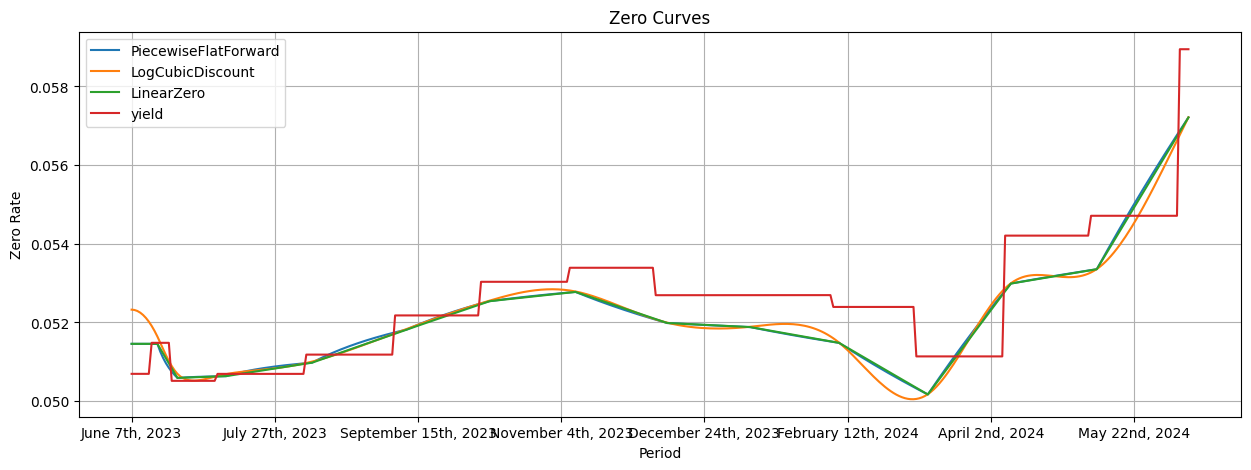

In [9]:
NotebookHelper.plot_zero_rates(curve_dates, methods_curves, settings, index_curve_name, df_raw_yields)

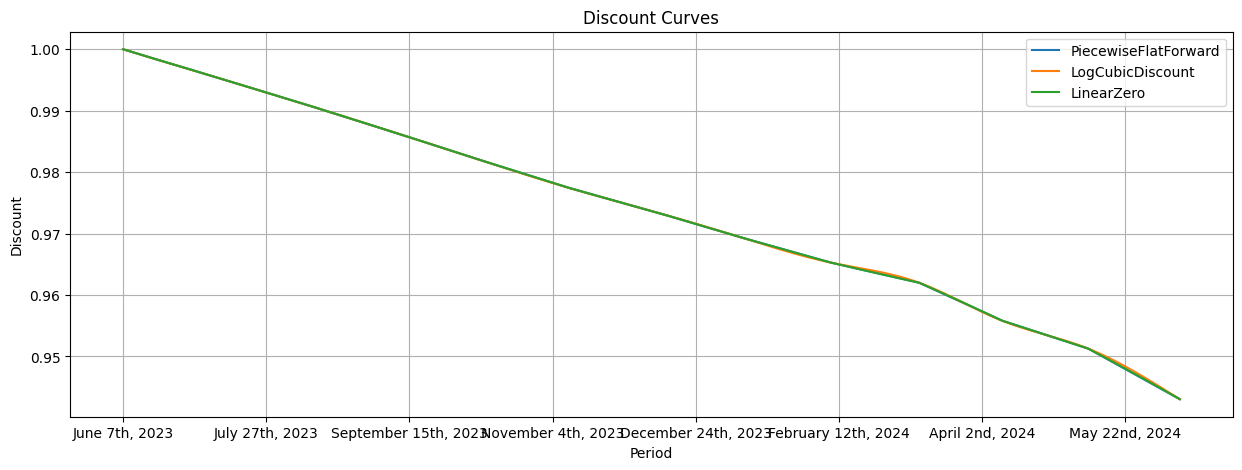

In [10]:
NotebookHelper.plot_discount(curve_dates, methods_curves, settings, index_curve_name)